In [47]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import AutoModel

model_name_or_path = "TheBloke/Llama-2-7b-Chat-GPTQ"
# To use a different branch, change revision
# For example: revision="gptq-4bit-64g-actorder_True"
model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

encoder_model_name = "princeton-nlp/unsup-simcse-roberta-large"
encoder = AutoModel.from_pretrained(encoder_model_name).to(model.device)
encoder_tokenizer = AutoTokenizer.from_pretrained(encoder_model_name, use_fast=True)

In [61]:
target_sentence = """
5/25/2003

Dear diary,

today I realized I had a crush on Jorden and his older brother, Kaylen.

I just might dream about them.

Also, dad bought a grill.
""".strip()

prompt = "Close your eyes, and tell me what do you see"

prompt_template=f'''[INST] <<SYS>>
You are very imaginative and creative, and you are picturing a scene in your mind. The scene is about """{target_sentence}"""
A ultra realistic scene begins to show up...<</SYS>>
{prompt}[/INST]

I see'''

target_token_len = len(tokenizer.encode(target_sentence))

# output = model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=512)
# print(tokenizer.decode(output[0]))
prompt_template

'[INST] <<SYS>>\nYou are very imaginative and creative, and you are picturing a scene in your mind. The scene is about """5/25/2003\n\nDear diary,\n\ntoday I realized I had a crush on Jorden and his older brother, Kaylen.\n\nI just might dream about them.\n\nAlso, dad bought a grill."""\nA ultra realistic scene begins to show up...<</SYS>>\nClose your eyes, and tell me what do you see[/INST]\n\nI see'

In [62]:
tokenizer.decode(tokenizer.encode(prompt_template)[36: 36+target_token_len])

'5/25/2003\n\nDear diary,\n\ntoday I realized I had a crush on Jorden and his older brother, Kaylen.\n\nI just might dream about them.\n\nAlso, dad bought a grill."""\n'

In [63]:
input_length = len(tokenizer.encode(prompt_template))

In [64]:
from transformers.models.llama.modeling_llama import LlamaAttention, warnings, apply_rotary_pos_emb, repeat_kv
import torch
from torch import nn
from torch.nn import functional as F
from typing import Optional, List, Union, Tuple
import math

def forward(
    self,
    hidden_states: torch.Tensor,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    past_key_value: Optional[Tuple[torch.Tensor]] = None,
    output_attentions: bool = False,
    use_cache: bool = False,
    **kwargs,
) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
    if "padding_mask" in kwargs:
        warnings.warn(
            "Passing `padding_mask` is deprecated and will be removed in v4.37. Please make sure use `attention_mask` instead.`"
        )

    bsz, q_len, _ = hidden_states.size()

    if self.config.pretraining_tp > 1:
        key_value_slicing = (self.num_key_value_heads * self.head_dim) // self.config.pretraining_tp
        query_slices = self.q_proj.weight.split(
            (self.num_heads * self.head_dim) // self.config.pretraining_tp, dim=0
        )
        key_slices = self.k_proj.weight.split(key_value_slicing, dim=0)
        value_slices = self.v_proj.weight.split(key_value_slicing, dim=0)

        query_states = [F.linear(hidden_states, query_slices[i]) for i in range(self.config.pretraining_tp)]
        query_states = torch.cat(query_states, dim=-1)

        key_states = [F.linear(hidden_states, key_slices[i]) for i in range(self.config.pretraining_tp)]
        key_states = torch.cat(key_states, dim=-1)

        value_states = [F.linear(hidden_states, value_slices[i]) for i in range(self.config.pretraining_tp)]
        value_states = torch.cat(value_states, dim=-1)

    else:
        query_states = self.q_proj(hidden_states)
        key_states = self.k_proj(hidden_states)
        value_states = self.v_proj(hidden_states)

    query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

    kv_seq_len = key_states.shape[-2]
    if past_key_value is not None:
        kv_seq_len += past_key_value[0].shape[-2]
    cos, sin = self.rotary_emb(value_states, seq_len=kv_seq_len)
    query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin, position_ids)

    if past_key_value is not None:
        # reuse k, v, self_attention
        key_states = torch.cat([past_key_value[0], key_states], dim=2)
        value_states = torch.cat([past_key_value[1], value_states], dim=2)

    past_key_value = (key_states, value_states) if use_cache else None

    key_states = repeat_kv(key_states, self.num_key_value_groups)
    value_states = repeat_kv(value_states, self.num_key_value_groups)

    attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(self.head_dim)
    # print(attn_weights.shape)
    attn_weights[:, :, self.noise_start_id:self.noise_end_id, self.noise_start_id:self.noise_end_id] *= self.noise_attention_multiplier

    if attn_weights.size() != (bsz, self.num_heads, q_len, kv_seq_len):
        raise ValueError(
            f"Attention weights should be of size {(bsz, self.num_heads, q_len, kv_seq_len)}, but is"
            f" {attn_weights.size()}"
        )

    if attention_mask is not None:
        if attention_mask.size() != (bsz, 1, q_len, kv_seq_len):
            raise ValueError(
                f"Attention mask should be of size {(bsz, 1, q_len, kv_seq_len)}, but is {attention_mask.size()}"
            )
        attn_weights = attn_weights + attention_mask

    # upcast attention to fp32
    attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
    attn_output = torch.matmul(attn_weights, value_states)

    if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
        raise ValueError(
            f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
            f" {attn_output.size()}"
        )

    attn_output = attn_output.transpose(1, 2).contiguous()

    attn_output = attn_output.reshape(bsz, q_len, self.hidden_size)

    if self.config.pretraining_tp > 1:
        attn_output = attn_output.split(self.hidden_size // self.config.pretraining_tp, dim=2)
        o_proj_slices = self.o_proj.weight.split(self.hidden_size // self.config.pretraining_tp, dim=1)
        attn_output = sum([F.linear(attn_output[i], o_proj_slices[i]) for i in range(self.config.pretraining_tp)])
    else:
        attn_output = self.o_proj(attn_output)

    if not output_attentions:
        attn_weights = None

    return attn_output, attn_weights, past_key_value


def monkeypatch_llama(noise_attention_multiplier= 0.1):
    LlamaAttention.forward = forward
    LlamaAttention.noise_start_id = 36
    LlamaAttention.noise_end_id = 36+target_token_len
    LlamaAttention.noise_attention_multiplier = noise_attention_multiplier



# # testing
monkeypatch_llama(0.1)
# generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
# print(generator(prompt_template, max_new_tokens=500)[0]['generated_text'])

In [65]:
import numpy as np

with torch.no_grad():
    target_embedding = encoder(**encoder_tokenizer(target_sentence, return_tensors="pt").to(encoder.device)).last_hidden_state.mean(dim=1)

def compare(result):
    with torch.no_grad():
        result_embedding = encoder(**encoder_tokenizer(result, return_tensors="pt").to(encoder.device)).last_hidden_state.mean(dim=1)
        similarity = F.cosine_similarity(result_embedding, target_embedding)

    return similarity.item(), result_embedding

def generate(noise_attention_multiplier):
    monkeypatch_llama(noise_attention_multiplier)
    input_tokens = tokenizer.encode(prompt_template, return_tensors="pt").to(model.device)
    input_length = input_tokens.shape[1]

    with torch.no_grad():
        outputs = model.generate(input_tokens, max_new_tokens=500)

    result = tokenizer.decode(outputs[0][input_length:])
    return result


embeddings = []
results = []

for multiplier in np.arange(0, 1, 0.05):
    result = generate(multiplier)
    sim, emb = compare(result)
    embeddings.append(emb)
    results.append(result)
    print(f"Multiplier: {multiplier}, Similarity: {sim}")

Multiplier: 0.0, Similarity: 0.18159005045890808
Multiplier: 0.05, Similarity: 0.20032498240470886
Multiplier: 0.1, Similarity: 0.1899690330028534
Multiplier: 0.15000000000000002, Similarity: 0.1899690330028534
Multiplier: 0.2, Similarity: 0.24456998705863953
Multiplier: 0.25, Similarity: 0.27345743775367737
Multiplier: 0.30000000000000004, Similarity: 0.2371552288532257
Multiplier: 0.35000000000000003, Similarity: 0.2843407988548279
Multiplier: 0.4, Similarity: 0.22287358343601227
Multiplier: 0.45, Similarity: 0.29037266969680786
Multiplier: 0.5, Similarity: 0.25084471702575684
Multiplier: 0.55, Similarity: 0.5788987874984741
Multiplier: 0.6000000000000001, Similarity: 0.4767531752586365
Multiplier: 0.65, Similarity: 0.3546468913555145
Multiplier: 0.7000000000000001, Similarity: 0.33083784580230713
Multiplier: 0.75, Similarity: 0.5108069181442261
Multiplier: 0.8, Similarity: 0.4678788483142853
Multiplier: 0.8500000000000001, Similarity: 0.4199870228767395
Multiplier: 0.9, Similarity: 

In [66]:
for result in results:
    print(result)
    print('\n\n\n')

a vibrant and colorful scene unfolding in my mind's eye. The setting is a bustling marketplace in a far-off land, filled with exotic sights and sounds. The sun is high overhead, casting a warm glow over the entire scene.
As I look around, I see a variety of vendors selling their wares. There are stalls selling fresh fruits and vegetables, others offering handmade crafts and trinkets, and a few vendors even selling rare and exotic spices. The smells of the food and spices fill the air, making my mouth water.
In the center of the marketplace, I see a large, ornate fountain, with water flowing from intricate carvings of mythical creatures. People are gathered around the fountain, drinking from cups and basins, and washing their hands and faces.
As I look closer, I notice a group of people gathered around a man who is playing a beautiful, intricate melody on a traditional instrument. The music is haunting and mesmerizing, and I can feel the rhythm pulsing through my body.
Suddenly, a group

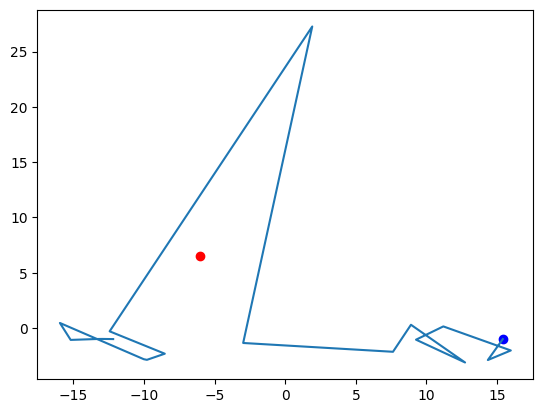

In [67]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_cpu = torch.cat(embeddings).cpu().numpy()
target_embedding_cpu = target_embedding.cpu().numpy()

pca.fit(embeddings_cpu)

import matplotlib.pyplot as plt
plt.scatter(pca.transform(embeddings_cpu)[0, 0], pca.transform(embeddings_cpu)[0, 1], color="blue")
plt.plot(pca.transform(embeddings_cpu)[:, 0], pca.transform(embeddings_cpu)[:, 1])
plt.scatter(pca.transform(target_embedding_cpu)[:, 0], pca.transform(target_embedding_cpu)[:, 1], color="red")
plt.show()

In [68]:
# from termcolor import colored, cprint

# # cprint("Prompt:", "green")

# def cosine_similarity(a, b):
#     return torch.dot(a, b) / (torch.norm(a) * torch.norm(b))


# top_k = 20
# hint_weight = 5
# hint_weight_decay = 1.01
# # reptition_penalty = 0.98

# past_key_values = None

# input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
# input_length = len(input_ids[0])
# ids_so_far = input_ids
# generation_mask = []

# embeddings = []


# with torch.no_grad():
#     for i in range(400):
#         output = model(input_ids=input_ids, return_dict=True, past_key_values=past_key_values)
#         logits = output.logits[0]
#         past_key_values = output.past_key_values

#         top_tokens = torch.topk(logits[-1], top_k).indices
#         raw_best_token = torch.argmax(logits[-1])

#         best_score = -10000
#         best_token = None

#         for top_token in top_tokens:
#             concat_indices = torch.cat([ids_so_far[0][input_length:], top_token.unsqueeze(0)])
#             string = tokenizer.decode(concat_indices)
#             encoder_tokens = encoder_tokenizer(string, return_tensors='pt').input_ids.cuda()
#             embedding = encoder(input_ids=encoder_tokens).pooler_output
#             similarity = cosine_similarity(target_embedding, embedding[0])

#             similarity = torch.max(similarity, torch.tensor(1e-5).to(model.device))

#             # seen_times = 0
#             # for token in ids_so_far[0][:-10]:
#             #     if token == top_token:
#             #         seen_times += 1

#             score = torch.log(similarity) * hint_weight + torch.log(logits[-1][top_token])
#             # score = score * (reptition_penalty ** seen_times)
#             # print(torch.log(similarity), torch.log(logits[-1][top_token]), score)
#             if score > best_score:
#                 best_score = score
#                 best_token = top_token
#                 embeddings.append(embedding)

#         if best_token == raw_best_token:
#             # print("Raw best token is the best token")
#             generation_mask.append(1)
#             cprint(tokenizer.decode(best_token), end=" ", color="green")
#         else:
#             generation_mask.append(0)
#             cprint(tokenizer.decode(best_token), end=" ", color="red")

#         ids_so_far = torch.cat([ids_so_far, best_token.unsqueeze(0).unsqueeze(0)], dim=-1)
#         input_ids = best_token.unsqueeze(0).unsqueeze(0)

#         hint_weight *= hint_weight_decay

#         if i % 50 == 0:
#             # print(tokenizer.decode(ids_so_far[0]), end=" ")
#             print('\n')
#             print('similarity:', similarity)
#             for i in range(len(generation_mask)):
#                 if generation_mask[i] == 1:
#                     cprint(tokenizer.decode(ids_so_far[0][input_length + i]), end=" ", color="green")
#                 else:
#                     cprint(tokenizer.decode(ids_so_far[0][input_length + i]), end=" ", color="red")
#             print('\n\n')
#         # break
#         # best_token = torch.argmax(logits[-1])
#         # ids_so_far = torch.cat([ids_so_far, best_token.unsqueeze(0).unsqueeze(0)], dim=-1)

#         # input_ids = torch.cat([input_ids, best_token.unsqueeze(0).unsqueeze(0)], dim=-1)input_ids
#         # input_ids = best_token.unsqueeze(0).unsqueeze(0)

In [69]:
# print(tokenizer.decode(ids_so_far[0][input_length:]))

In [70]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)

# embeddings_array = torch.cat(embeddings).cpu().numpy()
# target_embeddings_cpu = target_embedding.cpu().numpy()

# pca.fit(embeddings_array)

# embeddings_pca = pca.transform(embeddings_array)
# target_embedding_pca = pca.transform(target_embeddings_cpu.reshape(1, -1))

# import matplotlib.pyplot as plt
# plt.plot(embeddings_pca[:, 0], embeddings_pca[:, 1])
# plt.scatter(target_embedding_pca[:, 0], target_embedding_pca[:, 1], color='red')
# plt.show()

In [71]:
# for i in range(len(generation_mask)):
#     if generation_mask[i] == 1:
#         cprint(tokenizer.decode(ids_so_far[0][input_length + i]), end=" ", color="green")
#     else:
#         cprint(tokenizer.decode(ids_so_far[0][input_length + i]), end=" ", color="red")

In [72]:
# hint_weight = 5

In [73]:
# import os

# i = 1
# while os.path.exists(f"../dream/story{i}.txt"):
#     i += 1

# with open(f"../dream/story{i}.txt", "w") as f:
#     f.write(f"Hint: {target_sentence}\n\n")
#     f.write(f"Top k: {top_k}\n")
#     f.write(f"Hint weight: {hint_weight}\n\n")
#     f.write(tokenizer.decode(ids_so_far[0]))